 <font size="6">Project- Neural Network based Image & Query Search</font>

BA865 Group 9:

- Amisha Kelkar, Shrinidhi Bhide, Yashna Meher


# Problem Definition
Current image retrieval systems predominantly rely on large, pretrained models such as CLIP or BERT, which can introduce limitations around interpretability, modularity, and data privacy—especially for organizations needing internal or domain-specific solutions. Furthermore, most systems treat search as a single-directional task (e.g., text-to-image only), limiting flexibility. This project aims to develop a lightweight, modular neural model for multimodal retrieval from scratch, without relying on pretrained encoders. The system is designed to handle three core tasks: (1) retrieving relevant images from text queries, (2) enabling image-to-image retrieval through caption generation, and (3) learning a shared embedding space for unified cross-modal retrieval. This approach provides a deeper understanding of the mechanics of sentence-image alignment while offering the potential for multilingual and customizable extensions in the future.

Through this project we have tried to attempt all three. The following notebook has the 3 trials in the following sequence-
1. Retrieve images based on comparing captions with the query
2. Captioning images received which can be tied back to the first approach and retrieve images
3. Image retrieval from a joint embedding space of both captions and images in the data set.


**Dataset**<br>
We are using the Flickr30k dataset, which has: <br>
- Around 31,000 images, each with 5 captions written by humans
- Total: ~150,000 image-caption pairs
- The images are in JPEG format and the captions are plain English text
Link to dataset: http://shannon.cs.illinois.edu/DenotationGraph/

**Important Note:** Since the dataset was requested from UIUC, we have saved it to our GCP bucket. We will attach a JSON file with validation credentials which needs to be uploaded into the memory of the colab session for this code to work.

#Data Loading (Captions and Images)

In [1]:
!pip install google-cloud-storage
#Imports
from google.cloud import storage
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics.pairwise import cosine_similarity
from PIL import Image
import os
import json
import matplotlib.pyplot as plt
from io import BytesIO

# GCS setup
BUCKET_NAME = 'flickr-images-ba865-project'
IMAGE_FOLDER = 'flickr30k-images/'
CAPTIONS_FILE = 'extracted_folder/captions_json.json'

# Authenticate with Google Cloud using the service account key file
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/content/ba865-spring25-project-44a6dd40a0c2.json"

# GCS client
client = storage.Client()




To load the captions

In [2]:
def load_captions_for_images(valid_image_paths):
    bucket = client.bucket(BUCKET_NAME)
    blob = bucket.blob(CAPTIONS_FILE)
    captions_json = blob.download_as_string()
    captions_dict = json.loads(captions_json)

    filtered_captions = {
        path: captions_dict[os.path.basename(path)]
        for path in valid_image_paths
        if os.path.basename(path) in captions_dict
    }

    return filtered_captions


The following code preprocesses a large number of images stored in a Google Cloud bucket by resizing and normalizing them, using multithreading (ThreadPoolExecutor) to do it efficiently in parallel. It returns a list of valid image arrays along with their corresponding file paths, skipping any images that cannot be downloaded or processed.

In [3]:
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm.notebook import tqdm

def preprocess_single_image(img_path, img_size=224):
    bucket = client.bucket(BUCKET_NAME)
    blob = bucket.blob(img_path)

    if not blob.exists():
        return None, None

    try:
        img_bytes = blob.download_as_bytes()
        img = Image.open(BytesIO(img_bytes)).convert('RGB').resize((img_size, img_size))
        return np.array(img) / 255.0, img_path
    except Exception:
        return None, None

def preprocess_images(num_images=None, img_size=224, max_workers=16):
    # Load all available caption metadata
    bucket = client.bucket(BUCKET_NAME)
    blob = bucket.blob(CAPTIONS_FILE)
    captions_json = blob.download_as_string()
    captions_dict = json.loads(captions_json)

    image_filenames = list(captions_dict.keys())
    if num_images is not None:
        image_filenames = image_filenames[:num_images]

    results = []
    valid_image_paths = []

    print(f"Preprocessing {len(image_filenames)} images...")
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = {
            executor.submit(preprocess_single_image, os.path.join(IMAGE_FOLDER, fname), img_size): fname
            for fname in image_filenames
        }

        for future in tqdm(as_completed(futures), total=len(futures), desc="Processing Images"):
            img_array, img_path = future.result()
            if img_array is not None:
                results.append(img_array)
                valid_image_paths.append(img_path)

    return results, valid_image_paths


In [4]:
# Load Captions and Preprocess Images
image_data, valid_paths = preprocess_images(num_images=8000)

# Get captions only for valid images
captions = load_captions_for_images(valid_paths)



Preprocessing 8000 images...


Processing Images:   0%|          | 0/8000 [00:00<?, ?it/s]

# Exploratory Data Analysis (EDA)

## Image- Caption Samples

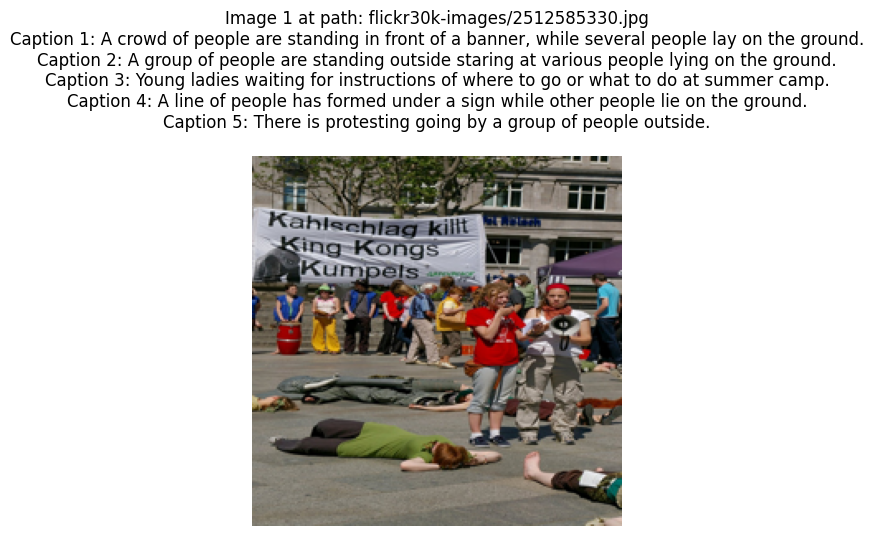

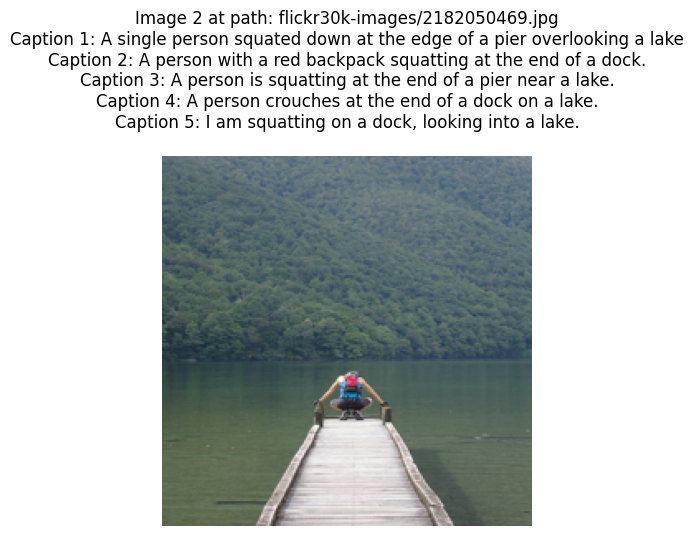

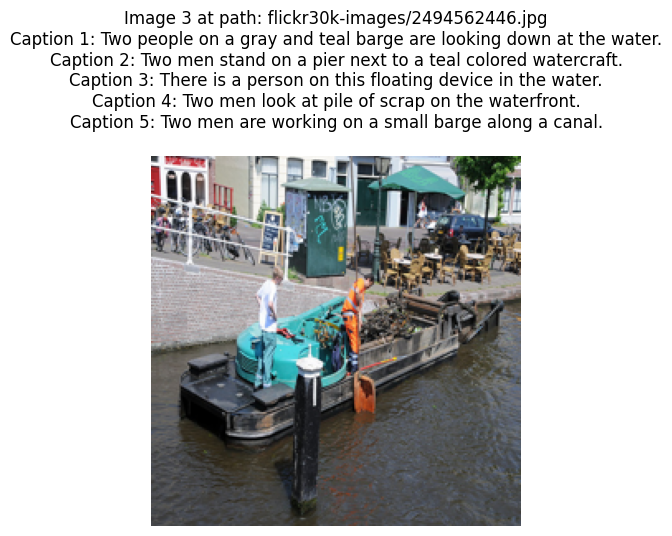

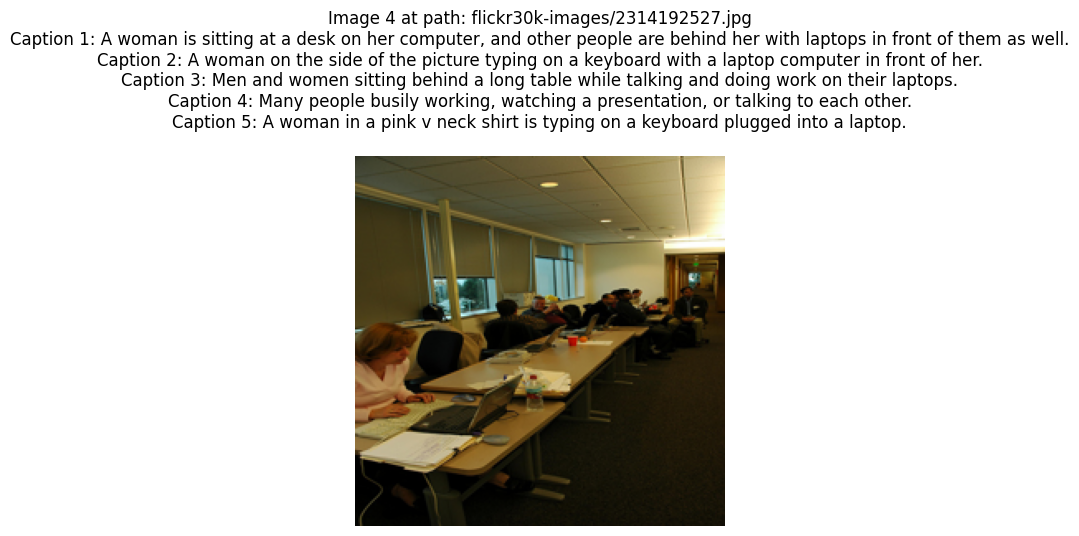

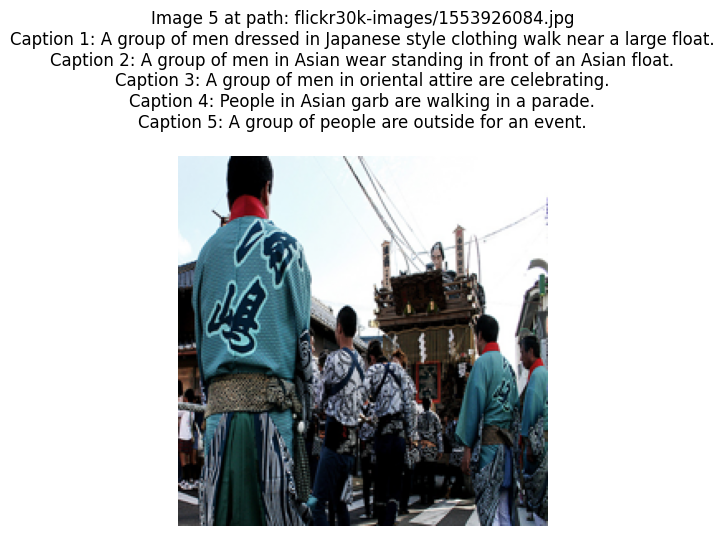

In [5]:
import matplotlib.pyplot as plt
import random
num_images_to_display = 5

# Get random image indices
random_image_indices = random.sample(range(len(image_data)), num_images_to_display)

# Display the images
for i, image_index in enumerate(random_image_indices):
    plt.figure()
    plt.imshow(image_data[image_index])  # Use the random index to access image data

    # Access captions using valid_paths[image_index] as the key
    image_captions = captions.get(valid_paths[image_index], [])

    # Build the title string with captions on new lines
    title = f"Image {i+1} at path: {valid_paths[image_index]}\n"  # Start with image path
    for j, caption in enumerate(image_captions):
        title += f"Caption {j+1}: {caption}\n"  # Add each caption on a new line

    plt.title(title)
    plt.axis('off')
    plt.show()

## Distribution of Caption Lengths

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


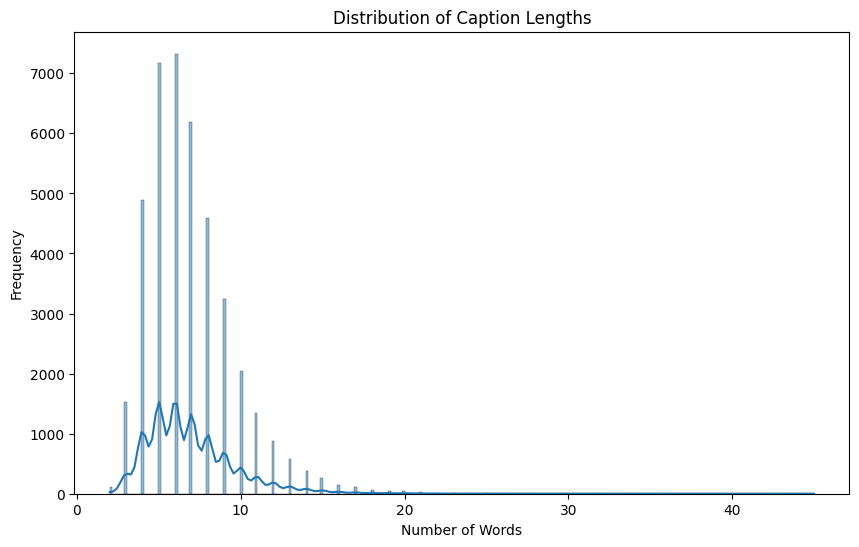

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

caption_lengths = [len([word for word in cap.lower().split() if word not in stop_words]) for caps in captions.values() for cap in caps]
plt.figure(figsize=(10, 6))
sns.histplot(caption_lengths, kde=True)
plt.title('Distribution of Caption Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()



This plot shows the distribution of caption lengths in terms of the number of words. Most captions are between 5 to 10 words long, with a sharp decline in frequency for longer captions, indicating a natural tendency toward concise image descriptions.

##Word Frequency Analysis (Top N frequent words)

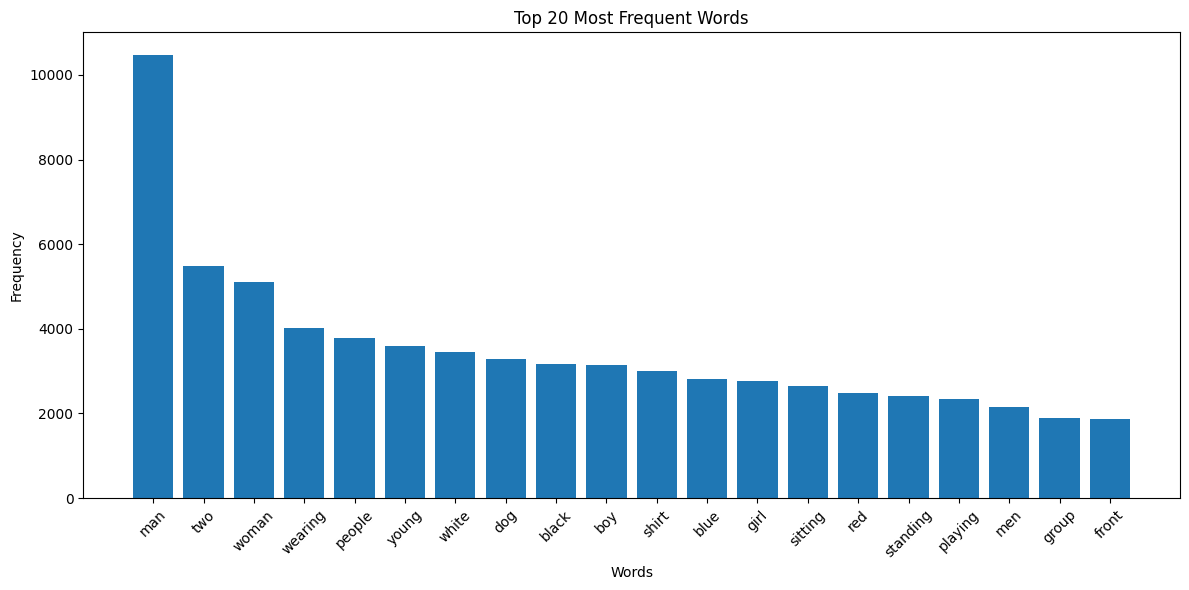

In [7]:
from collections import Counter
word_counts = Counter([word for caps in captions.values() for cap in caps for word in cap.lower().split() if word not in stop_words])
top_n = 20
most_common_words = word_counts.most_common(top_n)

words, counts = zip(*most_common_words)
plt.figure(figsize=(12, 6))
plt.bar(words, counts)
plt.title(f'Top {top_n} Most Frequent Words')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Trial 1- Image retrieval analyzing captions only.

The user will input a textual query and the model analyses the captions associated with the images (without analyzing the images) and displays the image which has a caption closest to the query.

## Caption Preprocessing<br>
To prepare the captions for model input, we first build a custom vocabulary by extracting all unique, non-stopword tokens from the dataset.
Each caption is then tokenized into a fixed-length sequence of word indices based on this vocabulary. Stopwords are removed to focus on more meaningful content words, and shorter sequences are padded to a consistent length for batch processing during training.

In [ ]:
# Tokenize Captions
def build_vocab(captions_dict):
    vocab = {'<pad>': 0, '<unk>': 1}
    idx = 2
    for caps in captions_dict.values():
        for cap in caps:
            for word in cap.lower().split():
                if word not in stop_words and word not in vocab:
                    vocab[word] = idx
                    idx += 1
    return vocab

def tokenize_caption(caption, vocab, max_len=10):
    tokens = [
        vocab.get(word, vocab['<unk>'])
        for word in caption.lower().split()
        if word not in stop_words
    ]
    tokens = tokens[:max_len] + [0] * (max_len - len(tokens))
    return tokens

# Build vocab and encode captions
vocab = build_vocab(captions)
vocab_size = len(vocab)

caption_seqs = []
caption_index = []
for path, caps in captions.items():
    for cap in caps:
        caption_seqs.append(tokenize_caption(cap, vocab))
        caption_index.append((path, cap))

caption_seqs = tf.constant(caption_seqs)

## Sentence Embedding Model with Cosine Similarity Loss<br>
We defined a custom neural network model to generate fixed-size sentence embeddings using an embedding layer followed by a BiLSTM and a dense projection layer. The final sentence representation is obtained using global average pooling over the sequence.
To improve the quality of the learned embeddings, we add a cosine similarity loss that aligns the pooled contextual embedding with the mean of raw (non-contextualized) token embeddings.

In [ ]:
class SentenceAlignModel(tf.keras.Model):
    def __init__(self, vocab_size, embed_dim):
        super().__init__()
        self.embedding = layers.Embedding(vocab_size, embed_dim, mask_zero=True)
        self.lstm = layers.Bidirectional(layers.LSTM(64, return_sequences=True))
        self.lstm_drop = layers.Dropout(0.5)
        self.dense = layers.Dense(128, activation='relu')
        self.pooling = layers.GlobalAveragePooling1D()

    def call(self, x):
        word_embeds = self.embedding(x)
        lstm_out = self.lstm(word_embeds)
        dense_out = self.dense(lstm_out)
        pooled_embed = self.pooling(dense_out)

        # Manual masking
        mask = tf.cast(tf.not_equal(x, 0), tf.float32)
        mask = tf.expand_dims(mask, -1)
        masked_embeds = word_embeds * mask
        sum_embeds = tf.reduce_sum(masked_embeds, axis=1)
        count = tf.reduce_sum(mask, axis=1) + 1e-8
        mean_embed = sum_embeds / count

        cosine_sim = tf.keras.losses.cosine_similarity(pooled_embed, mean_embed, axis=1)
        # cosine_loss=1-cosine_sim
        self.add_loss(tf.reduce_mean(cosine_sim))

        return pooled_embed


## Model Compilation and Training<br>
We compiled the `SentenceAlignModel` using the Adam optimizer. Since the model computes and adds its own cosine similarity loss internally, we do not need to provide an explicit loss function.

To fit the model, we use a dummy target array (`dummy_y`) that matches the output shape, as the loss is self-contained. The model is trained over 10 epochs.

We set `validation_split=0.2` during training, which automatically partitions 20% of the data for validation. This ensures that model performance is evaluated on unseen data during each epoch, helping detect overfitting and track generalization.  

In this approach,we did not use a separate test set due to the exploratory and self-supervised nature of the task. Since the model is trained using a custom internal loss (cosine similarity between contextual and raw embeddings), and we are not performing downstream classification, validation performance provides sufficient insight into model behavior.

In [ ]:
model = SentenceAlignModel(vocab_size=vocab_size, embed_dim=128)
model.compile(optimizer='adam')

dummy_y = tf.zeros((caption_seqs.shape[0], 128))


In [ ]:
model.fit(caption_seqs, dummy_y, epochs=10, batch_size=32,validation_split=0.2)

Epoch 1/10
1026/1026 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - loss: -0.8671 - val_loss: -0.9947
Epoch 2/10
1026/1026 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - loss: -0.9978 - val_loss: -0.9973
Epoch 3/10
1026/1026 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - loss: -0.9992 - val_loss: -0.9981
Epoch 4/10
1026/1026 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: -0.9994 - val_loss: -0.9984
Epoch 5/10
1026/1026 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: -0.9994 - val_loss: -0.9988
Epoch 6/10
1026/1026 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: -0.9996 - val_loss: -0.9991
Epoch 7/10
1026/1026 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: -0.9997 - val_loss: -0.9993
Epoch 8/10
1026/1026 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - loss: -0.9998 - val_loss: -0.9994
Epoch 9/10
1026/1026 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - loss: -0.9998 - val_loss: -0.9996
Epoch 10/10
1026/1026 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: -0.9999 - val_loss: -0.9996


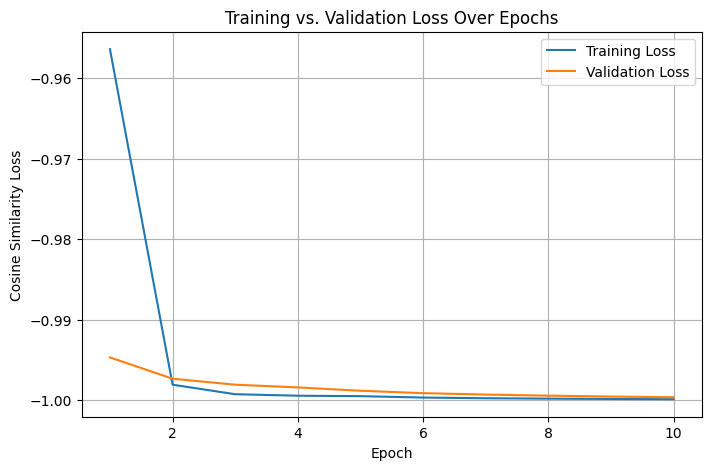

In [ ]:
import matplotlib.pyplot as plt
loss = model.history.history['loss']
val_loss = model.history.history['val_loss']

# Create the plot
epochs = range(1, len(loss) + 1)
plt.figure(figsize=(8, 5))
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Cosine Similarity Loss')
plt.title('Training vs. Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

We observe a steep initial drop in training loss, which quickly converges close to -1.0, indicating strong alignment between the contextual and raw mean embeddings. The validation loss also improves steadily and stabilizes, showing no major signs of overfitting. This confirms that the model is learning robust sentence representations that generalize well to unseen data.


## Image Retrieval


Then used the trained `SentenceAlignModel` to perform semantic image retrieval from natural language queries. <br>
Given a user query, we tokenize and encode it using the same preprocessing pipeline and pass it through the model to obtain its embedding. We then compute cosine similarity between the query embedding and all caption embeddings, retrieving the top-k most semantically similar image-caption pairs. This allows us to perform real-time, text-based image search using our custom alignment model.

In [ ]:
# Step 7: Inference

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
from PIL import Image
from io import BytesIO


caption_embeddings = model(caption_seqs).numpy()
caption_embeddings = normalize(caption_embeddings)


def retrieve_image(query, vocab, align_model, caption_embeddings, caption_index, client, BUCKET_NAME):
    # Tokenize and encode the query
    query_seq = tf.constant([tokenize_caption(query, vocab)])  # Already removes stopwords and pads

    # Pass query through your trained align model to get its embedding
    query_emb = model(query_seq).numpy()
    query_emb = normalize(query_emb)  # Optional: normalize for cosine similarity

    # Compute cosine similarities with precomputed caption embeddings
    sims = cosine_similarity(query_emb, caption_embeddings)[0]  # shape: (num_captions,)

    # Retrieve best match
    best_idx = np.argmax(sims)
    best_score = sims[best_idx]
    img_path, caption = caption_index[best_idx]

    # Load image from cloud bucket (GCS)
    bucket = client.bucket(BUCKET_NAME)
    blob = bucket.blob(img_path)
    img_bytes = blob.download_as_bytes()
    img_disp = Image.open(BytesIO(img_bytes))

    return img_disp, caption, best_score

from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity
from PIL import Image
from io import BytesIO

def retrieve_top_k_captions(query, vocab, align_model, caption_embeddings, caption_index, client, BUCKET_NAME, k=3):
    """
    Retrieve top-k images and captions based on cosine similarity using your SentenceAlignModel.
    """
    # Tokenize and embed the query
    query_seq = tf.constant([tokenize_caption("a photo of " + query, vocab)])  # includes augmentation
    query_emb = model(query_seq).numpy()
    query_emb = normalize(query_emb)

    # Normalize caption embeddings if not already
    caption_emb_norm = normalize(caption_embeddings)

    # Compute cosine similarity
    sims = cosine_similarity(query_emb, caption_emb_norm)[0]

    # Get top-k indices sorted by similarity
    top_k_idx = sims.argsort()[-k:][::-1]

    # Retrieve images and captions
    results = []
    for idx in top_k_idx:
        img_path, caption = caption_index[idx]
        sim = sims[idx]
        bucket = client.bucket(BUCKET_NAME)
        blob = bucket.blob(img_path)
        img_bytes = blob.download_as_bytes()
        img_disp = Image.open(BytesIO(img_bytes))

        results.append((img_disp, caption, sim))

    return results



To test our trained model, we input a natural language query and retrieve the most semantically similar image from the dataset based on cosine similarity in the shared embedding space.The retrieved image is displayed along with the matched caption and its similarity score.

Matched Caption: A man, leaning against a concrete wall with his arms resting on top, looks over a balcony.
Cosine Similarity: 1.0000


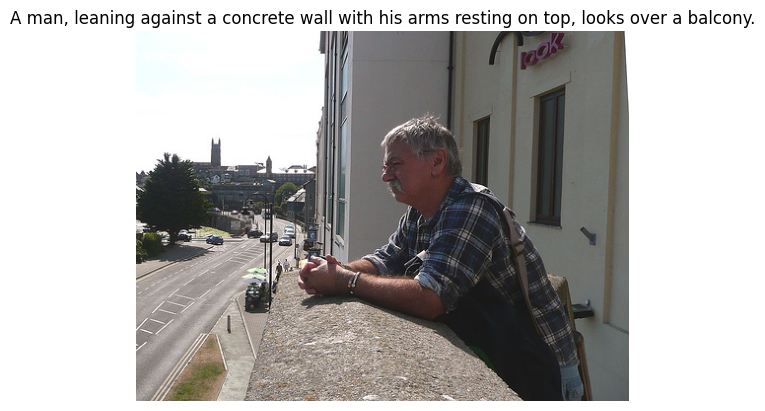

In [ ]:
query = "A man, leaning against a concrete wall with his arms resting on top, looks over a balcony."

img, cap, sim = retrieve_image(query, vocab, model, caption_embeddings, caption_index, client, BUCKET_NAME)
print(f"Matched Caption: {cap}")
print(f"Cosine Similarity: {sim:.4f}")
plt.imshow(img)
plt.title(cap)
plt.axis('off')
plt.show()

Matched Caption: People stand on a colorful balcony.
Cosine Similarity: 0.9994


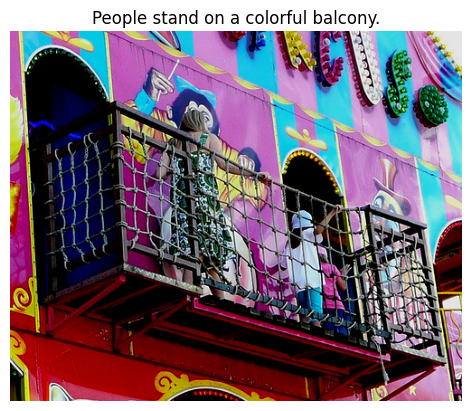

In [ ]:
query = "A man, leaning against a concrete wall looking over a balcony."

img, cap, sim = retrieve_image(query, vocab, model, caption_embeddings, caption_index, client, BUCKET_NAME)
print(f"Matched Caption: {cap}")
print(f"Cosine Similarity: {sim:.4f}")
plt.imshow(img)
plt.title(cap)
plt.axis('off')
plt.show()

Matched Caption: Children playing at the beach
Cosine Similarity: 1.0000


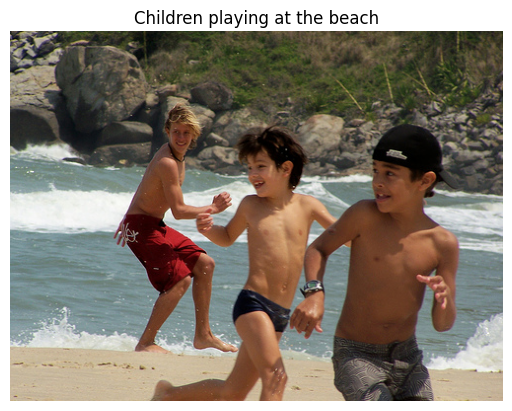

In [ ]:
query = 'children playing'
img, cap, sim = retrieve_image(query, vocab, model, caption_embeddings, caption_index, client, BUCKET_NAME)
print(f"Matched Caption: {cap}")
print(f"Cosine Similarity: {sim:.4f}")
plt.imshow(img)
plt.title(cap)
plt.axis('off')
plt.show()

Matched Caption: A child girl playing in the water
Cosine Similarity: 1.0000


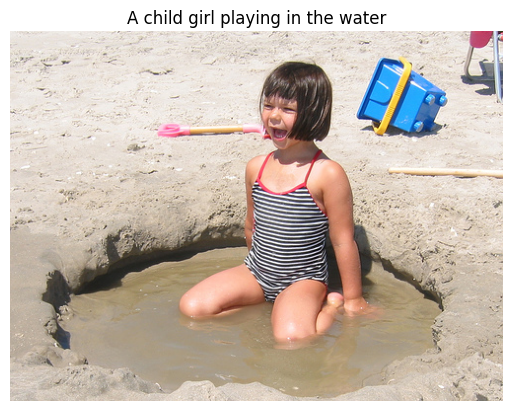

In [ ]:
query = "A dog playing"
img, cap, sim = retrieve_image(query, vocab, model, caption_embeddings, caption_index, client, BUCKET_NAME)
print(f"Matched Caption: {cap}")
print(f"Cosine Similarity: {sim:.4f}")
plt.imshow(img)
plt.title(cap)
plt.axis('off')
plt.show()

Matched Caption: A closeup of a guitar playing singing during a concert
Cosine Similarity: 0.9988


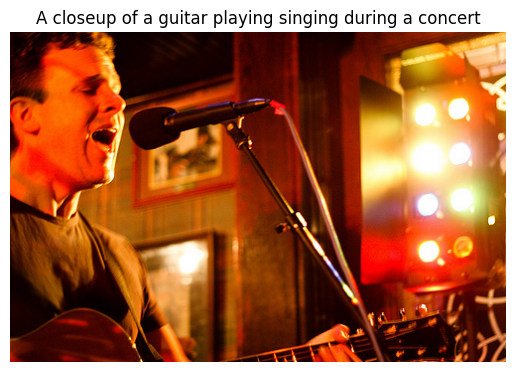

In [ ]:
query = "singing with guitar"
img, cap, sim = retrieve_image(query, vocab, model, caption_embeddings, caption_index, client, BUCKET_NAME)
print(f"Matched Caption: {cap}")
print(f"Cosine Similarity: {sim:.4f}")
plt.imshow(img)
plt.title(cap)
plt.axis('off')
plt.show()


# Trial 2- Using Image Embeddings for Caption Generation

After building our textual query-to-caption model, we moved on to step 2.

When the user inputs images as queries, the model could first generate captions describing the input image and then use the model we built in Trial 1 to find the closest image associated with the caption.

**Important Note**<br>
First model is without resnet, where we build a CNN from scratch, and the second one is using Resnet to extract image features. The latter is a somewhat better model, although neither works very well. This could be due to the lack of number of images in the training data due to compute constraints.

## 1. Image to caption transformer model

In this model, the user can input an image and the model returns a caption which describes that image.

### Loading the data

In [ ]:
!pip install google-cloud-storage
from google.cloud import storage
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics.pairwise import cosine_similarity
from PIL import Image
import os
import json
import matplotlib.pyplot as plt
from io import BytesIO

# GCS setup
BUCKET_NAME = 'flickr-images-ba865-project'
IMAGE_FOLDER = 'flickr30k-images/'
CAPTIONS_FILE = 'extracted_folder/captions_json.json'

# Authenticate with Google Cloud using the service account key file
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/content/ba865-spring25-project-44a6dd40a0c2.json"

# GCS client
client = storage.Client()




In [ ]:
# The previous functions but with an added feature of limiting the number of images we process

def load_captions_for_images(valid_image_paths):
    bucket = client.bucket(BUCKET_NAME)
    blob = bucket.blob(CAPTIONS_FILE)
    captions_json = blob.download_as_string()
    captions_dict = json.loads(captions_json)

    filtered_captions = {
        path: captions_dict[os.path.basename(path)]
        for path in valid_image_paths
        if os.path.basename(path) in captions_dict
    }

    return filtered_captions


In [ ]:
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm.notebook import tqdm

def preprocess_single_image(img_path, img_size=224):
    bucket = client.bucket(BUCKET_NAME)
    blob = bucket.blob(img_path)

    if not blob.exists():
        return None, None

    try:
        img_bytes = blob.download_as_bytes()
        img = Image.open(BytesIO(img_bytes)).convert('RGB').resize((img_size, img_size))
        return np.array(img) / 255.0, img_path
    except Exception:
        return None, None

def preprocess_images(num_images=None, img_size=224, max_workers=16):
    # Load all available caption metadata
    bucket = client.bucket(BUCKET_NAME)
    blob = bucket.blob(CAPTIONS_FILE)
    captions_json = blob.download_as_string()
    captions_dict = json.loads(captions_json)

    image_filenames = list(captions_dict.keys())
    if num_images is not None:
        image_filenames = image_filenames[:num_images]

    results = []
    valid_image_paths = []

    print(f"📦 Preprocessing {len(image_filenames)} images...")
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = {
            executor.submit(preprocess_single_image, os.path.join(IMAGE_FOLDER, fname), img_size): fname
            for fname in image_filenames
        }

        for future in tqdm(as_completed(futures), total=len(futures), desc="Processing Images"):
            img_array, img_path = future.result()
            if img_array is not None:
                results.append(img_array)
                valid_image_paths.append(img_path)

    return results, valid_image_paths


In [ ]:
# Step 2: Load Captions and Preprocess Images


# Process 100 images in parallel
image_data, valid_paths = preprocess_images(num_images=400)

# Get captions only for valid images
# captions = load_captions_for_images(valid_paths)



📦 Preprocessing 400 images...


Processing Images:   0%|          | 0/400 [00:00<?, ?it/s]

## Train test split

In [ ]:
# Step 3: Train test split

from sklearn.model_selection import train_test_split
import numpy as np

# Convert to NumPy arrays
image_data_np = np.array(image_data)
valid_paths_np = np.array(valid_paths)

# Split: 80% train, 20% test
X_train_imgs, X_test_imgs, train_paths, test_paths = train_test_split(
    image_data_np, valid_paths_np, test_size=0.2, random_state=42
)

captions_train = load_captions_for_images(train_paths.tolist())

captions_test = load_captions_for_images(test_paths.tolist())

## Pipeline building  (without resnet50)

### Vocabulary and tokenization

In [ ]:
from collections import Counter
import re

def preprocess_caption(caption):
    caption = re.sub(r"[^a-zA-Z ]", "", caption.lower())
    return caption.split()

def build_vocab(captions, min_freq=2):
    counter = Counter()
    for cap in captions:
        for word in preprocess_caption(cap):
            counter[word] += 1
    vocab = {'<pad>': 0, '<unk>': 1}
    for word, freq in counter.items():
        if freq >= min_freq:
            vocab[word] = len(vocab)
    return vocab

def tokenize_caption(caption, vocab, max_len=20):
    tokens = preprocess_caption(caption)
    token_ids = [vocab.get(word, vocab['<unk>']) for word in tokens]
    token_ids = token_ids[:max_len] + [vocab['<pad>']] * (max_len - len(token_ids))
    return token_ids


### Image feature extractor

This is designed to work as something analogous to Resnet.

In [ ]:
!pip install tensorflow
from tensorflow.keras import Model


This code builds a ResNet-50-like convolutional neural network from scratch (without pretrained weights) using identity and convolutional residual blocks, and wraps it into a feature extractor model that outputs 49 image patches of 2048-dim embeddings. It also includes a preprocessing and reshaping pipeline to prepare raw images for input into this custom encoder.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Input

# ——————————————————————————————————————————————————————
# 1) Your ResNet-50 “from scratch” (no weights)
# ——————————————————————————————————————————————————————
def identity_block(input_tensor, filters):
    f1, f2, f3 = filters
    x = layers.Conv2D(f1, 1, padding='same')(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(f2, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(f3, 1, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Add()([x, input_tensor])
    return layers.ReLU()(x)

def conv_block(input_tensor, filters, stride=2):
    f1, f2, f3 = filters
    # Main path
    x = layers.Conv2D(f1, 1, strides=stride, padding='same')(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(f2, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(f3, 1, padding='same')(x)
    x = layers.BatchNormalization()(x)

    # Shortcut path
    shortcut = layers.Conv2D(f3, 1, strides=stride, padding='same')(input_tensor)
    shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Add()([x, shortcut])
    return layers.ReLU()(x)

def build_resnet50_scratch(include_top=False, input_shape=(224,224,3)):
    img_input = Input(shape=input_shape)
    # Stem
    x = layers.Conv2D(64, 7, strides=2, padding='same')(img_input)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPool2D(3, strides=2, padding='same')(x)

    # Stages 2–5
    for filters, reps, stride in [
        ([64, 64, 256], 3, 1),
        ([128, 128, 512], 4, 2),
        ([256, 256, 1024], 6, 2),
        ([512, 512, 2048], 3, 2),
    ]:
        # first block in stage
        x = conv_block(x, filters, stride=stride)
        # rest identity
        for _ in range(reps-1):
            x = identity_block(x, filters)

    if include_top:
        x = layers.GlobalAveragePooling2D()(x)
        x = layers.Dense(1000, activation='softmax')(x)

    return Model(img_input, x, name='resnet50_scratch')

# Plugging it into your encoder/extraction pipeline

def build_image_encoder_scratch():
    """
    Returns a Keras model that:
      • takes (batch, 224,224,3)
      • outputs (batch, 7,7,2048)
    exactly like ResNet50(include_top=False, ...).
    """
    return build_resnet50_scratch(include_top=False, input_shape=(224,224,3))


def extract_image_features(model, imgs):
    """
    img preprocessing + forward pass + flatten to patches
    """
    # If we want to use the same pixel‐wise normalization:
    imgs = tf.keras.applications.resnet.preprocess_input(imgs)
    # Otherwise we could do our own:
    # imgs = (imgs / 255.0 - 0.5) * 2.0

    features = model.predict(imgs, batch_size=8)  # -> (batch, 7, 7, 2048)
    b, h, w, c = features.shape
    return features.reshape((b, h*w, c))           # -> (batch, 49, 2048)


# ——————————————————————————————————————————————————————
# 3) Sanity check
# ——————————————————————————————————————————————————————
if __name__ == "__main__":
    enc = build_image_encoder_scratch()
    print(enc.output_shape)   # should print (None, 7, 7, 2048)

    dummy = tf.random.uniform((2, 224, 224, 3))
    patches = extract_image_features(enc, dummy)
    print(patches.shape)      # should print (2, 49, 2048)


(None, 7, 7, 2048)
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
(2, 49, 2048)


### Batch preparation

This function prepares a training dataset by pairing each image embedding with all its captions, tokenizing and padding the captions, and then batching the data into a TensorFlow pipeline for efficient training. It flattens multi-caption inputs into parallel (image, caption) pairs and returns a shuffled and preprocessed tf.data.Dataset.

In [ ]:
import tensorflow as tf
import numpy as np
import tensorflow as tf

def prepare_dataset_multi_caption(image_features, captions_list, tokenizer, max_len, batch_size=32, shuffle_buffer=1000):
    """
    image_features: NumPy array or Tensor of shape (num_images, 49, embed_dim)
    captions_list: list or array of length num_images, each element is a list of captions (strings) for that image
    tokenizer: a fitted tokenizer (e.g., tf.keras.preprocessing.text.Tokenizer or TextVectorization) to convert text to sequences
    max_len: integer, the fixed sequence length to pad/truncate captions
    batch_size: batch size for the dataset
    shuffle_buffer: buffer size for shuffling
    """
    flat_image_feats = []   # will hold repeated image features
    flat_captions_text = [] # will hold all captions as strings

    # Flatten the image-caption pairs
    for i, img_feat in enumerate(image_features):
        captions_for_image = captions_list[i]
        for cap in captions_for_image:
            flat_image_feats.append(img_feat)
            flat_captions_text.append(cap)

    flat_image_feats = np.array(flat_image_feats)  # shape: (num_pairs, 49, embed_dim)

    # Tokenize all captions and pad to max_len
    seqs = tokenizer.texts_to_sequences(flat_captions_text)       # list of lists of token IDs
    seqs_padded = tf.keras.preprocessing.sequence.pad_sequences(
        seqs, maxlen=max_len, padding='post', truncating='post'
    )
    # seqs_padded is shape (num_pairs, max_len)

    # Create TensorFlow Dataset
    dataset = tf.data.Dataset.from_tensor_slices((flat_image_feats, seqs_padded))
    dataset = dataset.shuffle(shuffle_buffer).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset


### Models

This code defines a transformer-based model that aligns a tokenized caption with an image by applying multi-head attention from the caption (as query) to the image features (as key/value). Captions are embedded and combined with positional encodings, while image features are projected to match the embedding dimension, and the output is pooled to generate a single vector summarizing the caption-conditioned attention over the image.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np

class CaptionToImageAttention(tf.keras.Model):
    def __init__(self, vocab_size, embed_dim=128, num_heads=4, ff_dim=256):
        super().__init__()
        self.embedding = layers.Embedding(vocab_size, embed_dim)
        self.pos_encoding = self.add_weight(
            name="pos_encoding", shape=[1, 20, embed_dim], initializer="random_normal"
        )
        self.image_proj = layers.Dense(embed_dim)  # 👈 NEW: to match dims

        # 🐛 Remove the reshape layer
        # self.reshape_layer = layers.Reshape((49 * 2048,))

        self.attn = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            layers.Dense(ff_dim, activation="relu"),
            layers.Dense(embed_dim)
        ])
        self.norm1 = layers.LayerNormalization()
        self.norm2 = layers.LayerNormalization()
        self.global_avg = layers.GlobalAveragePooling1D()

    def call(self, caption_tokens, image_features):
        x = self.embedding(caption_tokens) + self.pos_encoding[:, :tf.shape(caption_tokens)[1], :]

        image_features_proj = self.image_proj(image_features)  # 👈 Project to embed_dim
        image_features_proj = tf.reshape(image_features_proj, (tf.shape(image_features_proj)[0], -1, tf.shape(image_features_proj)[-1]))

        attn_output = self.attn(query=x, key=image_features_proj, value=image_features_proj)
        x = self.norm1(x + attn_output)
        x = self.norm2(x + self.ffn(x))
        return self.global_avg(x)

This model maps high-dimensional image patch features (49 regions of 2048-dim) into a lower-dimensional embedding space by applying a dense layer and then averaging across all patches. The result is a single embedding vector per image, capturing its overall content.

In [ ]:
class ImageProjector(tf.keras.Model):
    def __init__(self, output_dim):
        super().__init__()
        self.proj = layers.Dense(output_dim)

    def call(self, x):
        return tf.reduce_mean(self.proj(x), axis=1)

This function computes a contrastive loss that encourages image and text embeddings from the same pair to be similar while pushing apart unrelated pairs. It normalizes both embeddings, computes pairwise similarities scaled by temperature, and applies softmax cross-entropy where each image should match its corresponding caption.

In [ ]:
def contrastive_loss(image_emb, text_emb, temperature=0.07):
    image_emb = tf.math.l2_normalize(image_emb, axis=1)
    text_emb = tf.math.l2_normalize(text_emb, axis=1)

    logits = tf.matmul(image_emb, text_emb, transpose_b=True) / temperature
    labels = tf.range(tf.shape(logits)[0])
    return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(tf.one_hot(labels, depth=tf.shape(logits)[1]), logits))


### Training loop

This training loop jointly optimizes a caption encoder and image encoder using contrastive loss, encouraging aligned image-text pairs. It also applies linear learning rate decay across epochs to stabilize training and prints the average loss per epoch.

In [ ]:
import tensorflow as tf

def train_model(train_ds, caption_encoder, image_encoder, epochs=10, lr=1e-4):
    initial_lr = lr
    optimizer = tf.keras.optimizers.Adam(learning_rate=initial_lr)

    for epoch in range(epochs):
        new_lr = initial_lr * (1.0 - epoch / float(epochs))
        optimizer.learning_rate.assign(new_lr)

        # training loop
        total_loss = 0.0
        step = 0
        for image_batch, caption_batch in train_ds:
            with tf.GradientTape() as tape:
                cap_emb = caption_encoder(caption_batch, image_batch)
                img_emb = image_encoder(image_batch)
                loss = contrastive_loss(img_emb, cap_emb)
            vars_ = caption_encoder.trainable_variables + image_encoder.trainable_variables
            grads = tape.gradient(loss, vars_)
            optimizer.apply_gradients(zip(grads, vars_))

            total_loss += loss.numpy()
            step += 1

        avg_loss = total_loss / step
        print(f"Epoch {epoch+1}/{epochs} — LR: {new_lr:.6f} — Loss: {avg_loss:.4f}")


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

# Ensure order matches the image features
ordered_caption_lists = [captions_train[img_path] for img_path in train_paths]
# Flatten all captions to fit tokenizer
flat_captions = [cap for caps in ordered_caption_lists for cap in caps]

# Build tokenizer
tokenizer = Tokenizer(oov_token='<unk>')
tokenizer.fit_on_texts(flat_captions)

vocab = tokenizer.word_index
# Add special tokens:
vocab['<pad>'] = 0
vocab['<unk>'] = 1
vocab_size = len(vocab) + 1

# Extract features
cnn_model = build_image_encoder_scratch()
X_train_feats = extract_image_features(cnn_model, X_train_imgs)
X_test_feats = extract_image_features(cnn_model, X_test_imgs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


In [ ]:

train_ds = prepare_dataset_multi_caption(
    image_features=X_train_feats,
    captions_list=ordered_caption_lists,
    tokenizer=tokenizer,
    max_len=20,
    batch_size=8
)


In [ ]:

caption_encoder = CaptionToImageAttention(vocab_size)
image_encoder = ImageProjector(output_dim=128)


In [ ]:
print("X_train_feats shape:", X_train_feats.shape)  # Should be (batch, 49, 2048)


X_train_feats shape: (320, 49, 2048)


In [ ]:
# Train model
train_model(train_ds, caption_encoder, image_encoder, epochs=6)

Epoch 1/6 — LR: 0.000100 — Loss: 2.0727
Epoch 2/6 — LR: 0.000083 — Loss: 2.0727
Epoch 3/6 — LR: 0.000067 — Loss: 2.0727
Epoch 4/6 — LR: 0.000050 — Loss: 2.0727
Epoch 5/6 — LR: 0.000033 — Loss: 2.0727
Epoch 6/6 — LR: 0.000017 — Loss: 2.0727


### Inference: Retrieve the best caption

Here the user will input images from the test set and the model will try to generate a query for it.

This function retrieves the most relevant caption for a given image by computing the cosine similarity between the image's embedding and embeddings of candidate captions. It tokenizes captions, encodes them with the image, normalizes embeddings, and selects the caption with the highest similarity score.

This does not work very well, maybe because our training dataset was too small, given our compute constraints. We used Resnet and it was a bit better, although not by a great extent.

In [ ]:
def retrieve_best_caption(query_image, candidate_captions, vocab, encoder, projector, max_len=20):
    tokenized = [tokenize_caption(c, vocab, max_len) for c in candidate_captions]
    caption_tensor = tf.constant(tokenized, dtype=tf.int32)
    query_img = tf.expand_dims(query_image, axis=0)

    img_emb = tf.math.l2_normalize(projector(query_img))
    cap_embs = encoder(caption_tensor, tf.repeat(query_img, len(tokenized), axis=0))
    cap_embs = tf.math.l2_normalize(cap_embs)

    sims = tf.reduce_sum(img_emb * cap_embs, axis=1)
    best_idx = tf.argmax(sims).numpy()
    return candidate_captions[best_idx], float(sims[best_idx])


In [ ]:
# Demo
from tensorflow.keras.preprocessing.text import Tokenizer

ordered_test_caption_lists = [captions_test[img_path] for img_path in test_paths]

# Flatten all captions to fit tokenizer
flat_test_captions = [cap for caps in ordered_test_caption_lists for cap in caps]

# Build tokenizer
tokenizer = Tokenizer(oov_token='<unk>')
tokenizer.fit_on_texts(flat_test_captions)

🔍 Test Image - Best Retrieved Caption:
Caption: "Two men pushing wheelbarrows, two men looking at them, they are in the desert near some block construction buildings."
Cosine Similarity: 0.0034


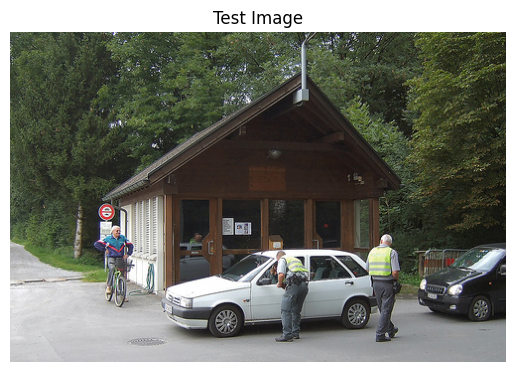

In [ ]:
test_img_index = 15
test_img_features = X_test_feats[test_img_index]

candidate_captions = [cap[test_img_index] if isinstance(cap, list) else cap for cap in captions_test]
# Run retrieval
# Pass test_img_features instead of test_img
best_caption, similarity_score = retrieve_best_caption(test_img_features, flat_test_captions, vocab, caption_encoder, image_encoder)

# Step 4: Print result
print("🔍 Test Image - Best Retrieved Caption:")
print(f"Caption: \"{best_caption}\"")
print(f"Cosine Similarity: {similarity_score:.4f}")

from PIL import Image
import matplotlib.pyplot as plt
from io import BytesIO

# Load and show image using its path
test_img_path = test_paths[test_img_index]

# Download image data from GCS
bucket = client.bucket(BUCKET_NAME)
blob = bucket.blob(test_img_path)
img_bytes = blob.download_as_bytes()

# Open image from bytes
img = Image.open(BytesIO(img_bytes))

plt.imshow(img)
plt.axis('off')
plt.title("Test Image")
plt.show()

🔍 Test Image - Best Retrieved Caption:
Caption: "Two men pushing wheelbarrows, two men looking at them, they are in the desert near some block construction buildings."
Cosine Similarity: 0.0034


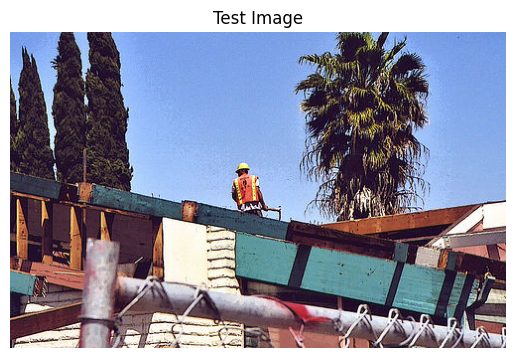

In [ ]:
# Pick a test image (e.g., first one)
test_img_index = 11
test_img_features = X_test_feats[test_img_index]
candidate_captions = [cap[test_img_index] if isinstance(cap, list) else cap for cap in captions_test]


# Retrieval
# Pass test_img_features instead of test_img
best_caption, similarity_score = retrieve_best_caption(test_img_features, flat_test_captions, vocab, caption_encoder, image_encoder)

# Step 4: Print result
print("🔍 Test Image - Best Retrieved Caption:")
print(f"Caption: \"{best_caption}\"")
print(f"Cosine Similarity: {similarity_score:.4f}")

from PIL import Image
import matplotlib.pyplot as plt
from io import BytesIO

# Load and show image using its path
test_img_path = test_paths[test_img_index]

# Download image data from GCS
bucket = client.bucket(BUCKET_NAME)
blob = bucket.blob(test_img_path)
img_bytes = blob.download_as_bytes()

# Open image from bytes
img = Image.open(BytesIO(img_bytes))

plt.imshow(img)
plt.axis('off')
plt.title("Test Image")
plt.show()

🔍 Test Image - Best Retrieved Caption:
Caption: "A man holds up an older man as the older man bends down to check out plants."
Cosine Similarity: 0.0017


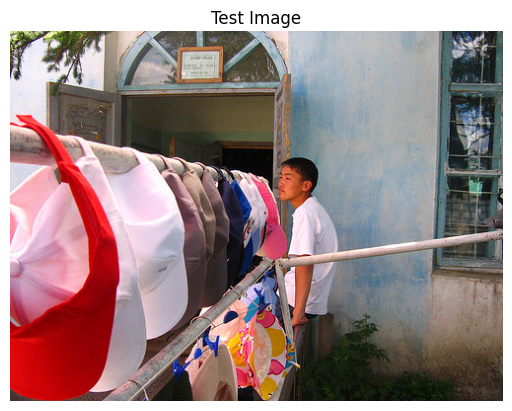

In [ ]:
# Pick a test image
test_img_index = 16
test_img_features = X_test_feats[test_img_index]

candidate_captions = [cap[test_img_index] if isinstance(cap, list) else cap for cap in captions_test]


# Retrieval
# Pass test_img_features instead of test_img
best_caption, similarity_score = retrieve_best_caption(test_img_features, flat_captions, vocab, caption_encoder, image_encoder)

# Step 4: Print result
print("🔍 Test Image - Best Retrieved Caption:")
print(f"Caption: \"{best_caption}\"")
print(f"Cosine Similarity: {similarity_score:.4f}")

from PIL import Image
import matplotlib.pyplot as plt
from io import BytesIO

# Load and show image using its path
test_img_path = test_paths[test_img_index]
# Download image data from GCS
bucket = client.bucket(BUCKET_NAME)
blob = bucket.blob(test_img_path)
img_bytes = blob.download_as_bytes()

# Open image from bytes
img = Image.open(BytesIO(img_bytes))

plt.imshow(img)
plt.axis('off')
plt.title("Test Image")
plt.show()

## ResNet Pipeline

This includes ResNet CNN, but otherwise, the pipeline is exactly the same.

### ResNet feature extractor

This code builds an image encoder using a pretrained ResNet-50 (without the classification head) to extract spatial feature maps from images. It then preprocesses input images, runs them through the model, and reshapes the output into a sequence of flattened patch features for downstream tasks.

In [ ]:
!pip install tensorflow
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import Model
from tensorflow.keras.applications.resnet50 import preprocess_input  # Import preprocess_input


In [ ]:
def build_image_encoder(output_dim=128):
    base_cnn = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
    model = Model(inputs=base_cnn.input, outputs=base_cnn.output)
    return model

def extract_image_features(model, imgs):
    imgs = preprocess_input(imgs)
    features = model.predict(imgs, batch_size=8)
    b, h, w, c = features.shape
    return features.reshape((b, h * w, c))


### Training loop

This training loop jointly optimizes a caption encoder and image encoder using contrastive loss, encouraging aligned image-text pairs.

In [ ]:
def train_model(train_ds, caption_encoder, image_encoder, epochs=10, lr=1e-4):
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

    for epoch in range(epochs):
        total_loss = 0.0
        step = 0
        for image_batch, caption_batch in train_ds:
            with tf.GradientTape() as tape:
                cap_emb = caption_encoder(caption_batch, image_batch)
                img_emb = image_encoder(image_batch)
                loss = contrastive_loss(img_emb, cap_emb)
            variables = caption_encoder.trainable_variables + image_encoder.trainable_variables
            grads = tape.gradient(loss, variables)
            optimizer.apply_gradients(zip(grads, variables))
            total_loss += loss.numpy()
            step += 1
        print(f"Epoch {epoch+1}, Loss: {total_loss/step:.4f}")


In [ ]:
# Ensure order matches the image features
ordered_caption_lists = [captions_train[img_path] for img_path in train_paths]



from tensorflow.keras.preprocessing.text import Tokenizer

# Flatten all captions to fit tokenizer
flat_captions = [cap for caps in ordered_caption_lists for cap in caps]

# Build tokenizer
tokenizer = Tokenizer(oov_token='<unk>')
tokenizer.fit_on_texts(flat_captions)


# Build vocab
vocab = build_vocab(flat_captions)
vocab_size = len(vocab)

# Extract features
cnn_model = build_image_encoder()
X_train_feats = extract_image_features(cnn_model, X_train_imgs)
X_test_feats = extract_image_features(cnn_model, X_test_imgs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


In [ ]:
train_ds = prepare_dataset_multi_caption(
    image_features=X_train_feats,
    captions_list=ordered_caption_lists,
    tokenizer=tokenizer,
    max_len=20,
    batch_size=8
)


In [ ]:

caption_encoder = CaptionToImageAttention(vocab_size)
image_encoder = ImageProjector(output_dim=128)


In [ ]:
print("X_train_feats shape:", X_train_feats.shape)


X_train_feats shape: (360, 49, 2048)


In [ ]:
# Train model
train_model(train_ds, caption_encoder, image_encoder, epochs=5)

Epoch 1, Loss: 2.0396
Epoch 2, Loss: 1.7055
Epoch 3, Loss: 1.1696
Epoch 4, Loss: 1.1468
Epoch 5, Loss: 1.0759


### Inference: Retrieve Best Caption

Here the user will input images from the test set and the model will try to generate a query for it.

This function retrieves the most relevant caption for a given image by computing the cosine similarity between the image's embedding and embeddings of candidate captions. It tokenizes captions, encodes them with the image, normalizes embeddings, and selects the caption with the highest similarity score.

This does not work very well, maybe because our training dataset was too small, given our compute constraints.

In [ ]:
def retrieve_best_caption(query_image, candidate_captions, vocab, encoder, projector, max_len=20):
    tokenized = [tokenize_caption(c, vocab, max_len) for c in candidate_captions]
    caption_tensor = tf.constant(tokenized, dtype=tf.int32)
    query_img = tf.expand_dims(query_image, axis=0)

    img_emb = tf.math.l2_normalize(projector(query_img))
    cap_embs = encoder(caption_tensor, tf.repeat(query_img, len(tokenized), axis=0))
    cap_embs = tf.math.l2_normalize(cap_embs)

    sims = tf.reduce_sum(img_emb * cap_embs, axis=1)
    best_idx = tf.argmax(sims).numpy()
    return candidate_captions[best_idx], float(sims[best_idx])


In [ ]:
# Demo
from tensorflow.keras.preprocessing.text import Tokenizer

ordered_test_caption_lists = [captions_test[img_path] for img_path in test_paths]

# Flatten all captions to fit tokenizer
flat_test_captions = [cap for caps in ordered_test_caption_lists for cap in caps]

test_sequences = tokenizer.texts_to_sequences(flat_test_captions)

🔍 Test Image - Best Retrieved Caption:
Caption: "Two men are grilling out."
Cosine Similarity: 0.0500


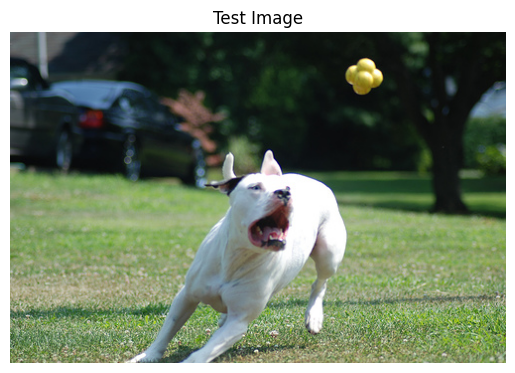

In [ ]:
# Pick a test image
test_img_index = 13
test_img_features = X_test_feats[test_img_index]

candidate_captions = [cap[test_img_index] if isinstance(cap, list) else cap for cap in captions_test]


# Retrieval
# Pass test_img_features instead of test_img
best_caption, similarity_score = retrieve_best_caption(test_img_features, flat_test_captions, vocab, caption_encoder, image_encoder)

# Step 4: Print result
print("🔍 Test Image - Best Retrieved Caption:")
print(f"Caption: \"{best_caption}\"")
print(f"Cosine Similarity: {similarity_score:.4f}")

from PIL import Image
import matplotlib.pyplot as plt
from io import BytesIO

# Load and show image using its path
test_img_path = test_paths[test_img_index]

# Download image data from GCS
bucket = client.bucket(BUCKET_NAME)
blob = bucket.blob(test_img_path)
img_bytes = blob.download_as_bytes()

# Open image from bytes
img = Image.open(BytesIO(img_bytes))

plt.imshow(img)
plt.axis('off')
plt.title("Test Image")
plt.show()

🔍 Test Image - Best Retrieved Caption:
Caption: "A girl blowing bubbles in the swimming pool."
Cosine Similarity: 0.0364


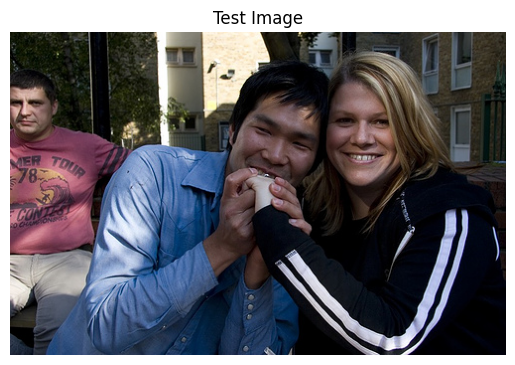

In [ ]:
# Pick a test image (e.g., first one)
test_img_index = 14
test_img_features = X_test_feats[test_img_index]

candidate_captions = [cap[test_img_index] if isinstance(cap, list) else cap for cap in captions_test]


# Retrieval
# Pass test_img_features instead of test_img
best_caption, similarity_score = retrieve_best_caption(test_img_features, flat_test_captions, vocab, caption_encoder, image_encoder)

# Print result
print("🔍 Test Image - Best Retrieved Caption:")
print(f"Caption: \"{best_caption}\"")
print(f"Cosine Similarity: {similarity_score:.4f}")

from PIL import Image
import matplotlib.pyplot as plt
from io import BytesIO

# Load and show image using its path
test_img_path = test_paths[test_img_index]

# Download image data from GCS
bucket = client.bucket(BUCKET_NAME)
blob = bucket.blob(test_img_path)
img_bytes = blob.download_as_bytes()

# Open image from bytes
img = Image.open(BytesIO(img_bytes))

plt.imshow(img)
plt.axis('off')
plt.title("Test Image")
plt.show()

# Trial 3- Using Image and Caption Embeddings Jointly for Image Retreival from Query<br>
In the last attempt we tried to get joint embeddings from both text and images. The idea was to ge text embedding and image embeddings separately and then get these 2 embeddings to interact in a joint space on which we finally train the model. The intent was to create an image search model which not only picks on the annotated captions of the image but also the embeddings and features which are learned from the images jointly in order to give image outputs. We have tried to creat a CNN from the scratch for the image embeddings, a RNN from the scratch for the text embeddings and then the joint model.

## Data Loading and Preprocessing(Both Images and Captions)

In [ ]:
# Imports
from google.cloud import storage
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics.pairwise import cosine_similarity
from PIL import Image
import os
import json
import matplotlib.pyplot as plt
from io import BytesIO
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import json
import cv2
import os
import random
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# GCS setup
BUCKET_NAME = 'flickr-images-ba865-project'
IMAGE_FOLDER = 'flickr30k-images/'
CAPTIONS_FILE = 'extracted_folder/captions_json.json'

# Authenticate with Google Cloud using the service account key file
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/content/ba865-spring25-project-44a6dd40a0c2.json"

# GCS client
client = storage.Client()

IMG_SHAPE = (128, 128, 3)
MAX_SEQ_LEN = 30
VOCAB_SIZE = 10000
BATCH_SIZE = 64
EMBED_DIM = 256


In [ ]:
bucket = client.bucket(BUCKET_NAME)
blob = bucket.blob(CAPTIONS_FILE)
captions_json = blob.download_as_string()
captions_dict = json.loads(captions_json)

image_filenames = list(captions_dict.keys())
image_filenames = image_filenames[:1500]

In [ ]:
import os
import cv2
import numpy as np
import subprocess

# GCS config
BUCKET_NAME = "flickr-images-ba865-project"
GCS_IMAGE_PATH = "flickr30k-images"

def load_and_resize_images(img_dir, image_files, size=(128, 128)):
    images = []
    for file in image_files:
        path = os.path.join(img_dir, file)
        img = cv2.imread(path)
        if img is None:
            print(f"Warning: {file} could not be loaded.")
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, size)
        img = img / 255.0
        images.append(img)
    return np.array(images)

def download_images_from_gcs(image_filenames, local_dir="flickr30k_images"):
    os.makedirs(local_dir, exist_ok=True)
    for filename in image_filenames:
        try:
            src = f"gs://{BUCKET_NAME}/{GCS_IMAGE_PATH}/{filename}"
            dst = os.path.join(local_dir, filename)
            subprocess.run(["gsutil", "cp", src, dst], check=True)
        except subprocess.CalledProcessError as e:
            print(f"Error downloading {filename}: {e}")


# download_images_from_gcs(image_filenames)
images = load_and_resize_images("flickr30k_images", image_filenames, size=(128, 128))
print(f"Loaded {len(images)} images.")


Loaded 1500 images.


We extracted all captions corresponding to the image filenames and fit a Keras tokenizer on them.  
The tokenizer was configured with a vocabulary size limit and an out-of-vocabulary token for unseen words.


In [ ]:
captions = [captions_dict[img] for img in image_filenames]
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<unk>")
tokenizer.fit_on_texts(captions)


## Constructing the Contrastive Learning Dataset<br>
The create_contrastive_dataset function prepares the training data needed for contrastive learning by generating structured (image, caption) pairs labeled as either positive (matched) or negative (mismatched). This setup enables the model to learn a joint embedding space where semantically similar image-caption pairs are close together, and unrelated pairs are far apart.

For each image, the function samples a correct caption, tokenizes it, and creates a positive pair labeled 1.0. To generate negatives, it randomly selects a different image, picks one of its captions, tokenizes it, and pairs it with the original image—labeling the result as 0.0. The same image and anchor caption are reused to form both types of pairs, helping the model learn to distinguish between relevant and irrelevant text.

This contrastive pairing is critical for the loss function to work effectively. It provides the necessary variation and supervision for the model to align image and caption representations, forming the foundation for tasks like image retrieval.

In [ ]:
def create_contrastive_dataset(images, captions, tokenizer, num_negatives=1):
    img_a, cap_a, query_b, labels = [], [], [], []
    N = len(images)

    for idx in range(N):
        img_array = images[idx]

        # positive caption (one string)
        pos_caption = random.choice(captions[idx])
        pos_seq = pad_sequences(
            tokenizer.texts_to_sequences([pos_caption]),
            maxlen=MAX_SEQ_LEN
        )[0]

        # positive sample: (image, caption) vs same caption
        img_a.append(img_array)
        cap_a.append(pos_seq)
        query_b.append(pos_seq)
        labels.append(1.0)

        # negatives
        for _ in range(num_negatives):
            wrong_idx = random.randint(0, N - 1)
            neg_caption = random.choice(captions[wrong_idx])
            neg_seq = pad_sequences(
                tokenizer.texts_to_sequences([neg_caption]),
                maxlen=MAX_SEQ_LEN
            )[0]

            img_a.append(img_array)
            cap_a.append(pos_seq)
            query_b.append(neg_seq)
            labels.append(0.0)

    return (
        np.asarray(img_a, dtype=np.float32),
        np.asarray(cap_a, dtype=np.int32),
        np.asarray(query_b, dtype=np.int32),
        np.asarray(labels, dtype=np.float32)
    )


    return map(np.asarray, (img_a, cap_a, query_b, labels))



## Image Encoder<br>
The build_image_encoder function constructs a deeper convolutional neural network designed to extract rich and high-level features from input images. It begins with four convolutional blocks, each consisting of a Conv2D layer followed by MaxPooling2D. These layers progressively capture low-to-high-level visual patterns while reducing spatial dimensions to retain the most important information. After the convolutional layers, the output is flattened and passed through a dense layer with 512 units activated by ReLU, allowing the network to learn complex, non-linear transformations. A dropout layer is added to reduce overfitting by randomly deactivating neurons during training. Finally, the network outputs a 256-dimensional dense embedding, which is normalized using L2 normalization to ensure embeddings lie on the unit hypersphere. This normalization is particularly useful in contrastive learning tasks where cosine similarity is used to compare image and text representations. Overall, this deeper architecture enhances the model’s ability to learn more discriminative image features, making it more effective for downstream tasks like image-text matching and retrieval.

In [ ]:
def build_image_encoder():
    inputs = Input(shape=IMG_SHAPE)

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(256)(x)
    x = Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(x)  # Normalize embedding

    model = Model(inputs, x)
    return model


## Caption Encoder<br>
The build_text_encoder function defines a deep recurrent neural network for generating dense, informative embeddings from text inputs (captions). It starts with an embedding layer that maps tokens to 256-dimensional vectors while using masking for padding. This is followed by 2 stacked bidirectional LSTM layers, which allow the model to capture both forward and backward context in the sequence. After the final LSTM, the output is passed through a fully connected layer with 256 units activated by ReLU to add non-linearity. Finally, L2 normalization is applied to ensure that the output embeddings lie on the unit hypersphere—making them suitable for cosine similarity comparisons in contrastive learning.

In [ ]:
def build_text_encoder(vocab_size, max_length):
    inputs = Input(shape=(max_length,))
    x = Embedding(vocab_size, 256, mask_zero=True)(inputs)
    x = Bidirectional(LSTM(256, return_sequences=True))(x)
    x = Bidirectional(LSTM(128))(x)
    x = Dense(256, activation='relu')(x)
    x = Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(x)
    model = Model(inputs, x)
    return model


## Joint Model- Image and Captions Together<br>
The build_joint_model function combines image and text encoders to create a shared embedding space for contrastive learning. It processes an image, its true caption, and a query caption. The image and caption embeddings are fused and passed through dense layers to produce a joint embedding (embedding_a), while the query caption is encoded separately as embedding_b. Both are L2-normalized and concatenated as the model's output.

In [ ]:
def build_joint_model(image_encoder, text_encoder):
    img_input = image_encoder.input
    cap_input = text_encoder.input
    query_input = Input(shape=(MAX_SEQ_LEN,))

    img_embed = image_encoder(img_input)
    cap_embed = text_encoder(cap_input)
    query_embed = text_encoder(query_input)

    # Fusion (Image + Caption)
    joint = concatenate([img_embed, cap_embed])
    x = Dense(512, activation='relu')(joint)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    embedding_a = Dense(256, activation='relu', name="joint_embedding")(x)
    embedding_a = Lambda(lambda t: tf.math.l2_normalize(t, axis=1))(embedding_a)
    embedding_b = query_embed

    output = concatenate([embedding_a, embedding_b])

    model = Model(inputs=[img_input, cap_input, query_input], outputs=output)
    return model


## Cosine Constrastive Loss<br>
This custom loss function, cosine_contrastive_loss, encourages similar image-caption pairs (y_true = 1) to have high cosine similarity and dissimilar pairs (y_true = 0) to stay apart by at least a defined margin. It calculates the cosine similarity between two embeddings and penalizes positive pairs for low similarity and negative pairs for being too close.

In [ ]:

def cosine_contrastive_loss(y_true, y_pred, margin=0.5):
    emb_a = y_pred[:, :256]
    emb_b = y_pred[:, 256:]
    emb_a = tf.math.l2_normalize(emb_a, axis=1)
    emb_b = tf.math.l2_normalize(emb_b, axis=1)

    cosine_sim = tf.reduce_sum(emb_a * emb_b, axis=1)

    pos_loss = y_true * (1 - cosine_sim)
    neg_loss = (1 - y_true) * tf.maximum(cosine_sim - margin, 0)

    return tf.reduce_mean(pos_loss + neg_loss)
import tensorflow as tf



## Compilation and Model Summary
This block initializes the image and text encoders, builds the joint model that fuses image-caption pairs, and compiles it using the custom cosine_contrastive_loss with a margin of 0.4. The Adam optimizer is used for efficient gradient updates. The model is then summarized to show the architecture, helping verify the input/output shapes and layer structure before training.


In [ ]:
from os.path import join
image_encoder = build_image_encoder()
text_encoder = build_text_encoder(VOCAB_SIZE, MAX_SEQ_LEN)
joint_model = build_joint_model(image_encoder, text_encoder)

joint_model.compile(optimizer='adam',loss=lambda y, y_pred: cosine_contrastive_loss(y, y_pred, margin=0.4))
joint_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 30)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional          │ (None, 256)       │  8,908,864 │ input_layer[0][0] │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_1        │ (None, 256)       │  4,332,800 │ input_layer_1[0]… │
│ (Functional)        │                   │            │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 512)       │          0 │ functional[0][0], │
│ (Concatenate)       │                   │            │ functional_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 512)       │    262,656 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 512)       │      2,048 │ dense_3[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 512)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ joint_embedding     │ (None, 256)       │    131,328 │ dropout_1[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 30)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, 256)       │          0 │ joint_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 512)       │          0 │ lambda_2[0][0],   │
│ (Concatenate)       │                   │            │ functional_1[1][… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 13,637,696 (52.02 MB)

 Trainable params: 13,636,672 (52.02 MB)

 Non-trainable params: 1,024 (4.00 KB)

In [ ]:
image_encoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     8,389,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 256)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,908,864 (33.98 MB)

 Trainable params: 8,908,864 (33.98 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
text_encoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 30)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 30, 256)   │  2,560,000 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 30)        │          0 │ input_layer_1[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 30, 512)   │  1,050,624 │ embedding[0][0],  │
│ (Bidirectional)     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 256)       │    656,384 │ bidirectional[0]… │
│ (Bidirectional)     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 256)       │     65,792 │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 256)       │          0 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,332,800 (16.53 MB)

 Trainable params: 4,332,800 (16.53 MB)

 Non-trainable params: 0 (0.00 B)

## Model Fitting<br>
The model is trained using image, caption, and query inputs generated through contrastive sampling. The dataset is split into training and validation sets using an 80-20 split to monitor generalization. To optimize training, callbacks are used:
- EarlyStopping halts training if validation loss doesn't improve for several epochs, avoiding overfitting.
- ReduceLROnPlateau lowers the learning rate when progress stalls, helping the model converge more smoothly.

The model is then trained for up to 20 epochs with a defined batch size, evaluating on the validation set at each step to guide learning through contrastive loss.


In [ ]:

X_img, X_cap, X_query, y_label = create_contrastive_dataset(images, captions, tokenizer, num_negatives=4)

X_img_train, X_img_val, X_cap_train, X_cap_val, X_query_train, X_query_val, y_train, y_val = train_test_split(
    X_img, X_cap, X_query, y_label, test_size=0.2, random_state=42)



from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=4,
    restore_best_weights=True,
    verbose=1
)


reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

history = joint_model.fit(
    [X_img_train, X_cap_train, X_query_train],
    y_train,
    validation_data=([X_img_val, X_cap_val, X_query_val], y_val),
    batch_size=BATCH_SIZE,
    epochs=10,
    callbacks=[early_stop, reduce_lr]
)



Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 446s 5s/step - loss: 0.1337 - val_loss: 0.1276 - learning_rate: 0.0010
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 416s 4s/step - loss: 0.1260 - val_loss: 0.1167 - learning_rate: 0.0010
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 442s 4s/step - loss: 0.1162 - val_loss: 0.0978 - learning_rate: 0.0010
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 400s 4s/step - loss: 0.1034 - val_loss: 0.0857 - learning_rate: 0.0010
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 467s 5s/step - loss: 0.0724 - val_loss: 0.0458 - learning_rate: 0.0010
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 432s 4s/step - loss: 0.0515 - val_loss: 0.0392 - learning_rate: 0.0010
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 432s 4s/step - loss: 0.0386 - val_loss: 0.0388 - learning_rate: 0.0010
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 467s 5s/step - loss: 0.0379 - val_loss: 0.0384 - learning_rate: 0.0010
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 424s 4s/step - loss: 0.0385 - val_loss: 0.0384 - learning_rate: 0.0010
Epoch 10/10
94/94 ━

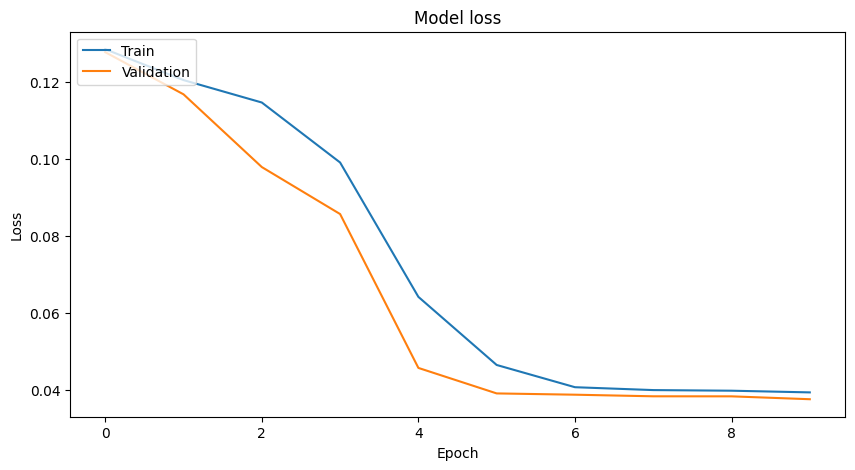

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


##Inference

**Query Encoder Extraction:**<br>
The function extract_query_encoder isolates the part of the joint model responsible for generating a query caption’s embedding, which is essential during inference.

In [ ]:
def extract_query_encoder(joint_model):
    query_input = joint_model.input[2]
    query_encoded = joint_model.get_layer('concatenate_1').output
    return Model(inputs=query_input, outputs=query_encoded)


**Database Embedding Computation:**<br>
Using compute_database_embeddings, the model processes each image and its caption to produce an embedding. These embeddings form the searchable vector space.



In [ ]:
def compute_database_embeddings(joint_embedding_model, images, captions, tokenizer):
    embeddings = []
    for idx in range(len(images)):
        img = images[idx]
        caption = captions[idx]

        img_array = np.expand_dims(img, axis=0)
        cap_seq = tokenizer.texts_to_sequences([caption])
        cap_seq = pad_sequences(cap_seq, maxlen=MAX_SEQ_LEN)

        embedding = joint_embedding_model.predict([img_array, cap_seq])
        embedding = np.squeeze(embedding)

        embeddings.append(embedding)

    embeddings = np.stack(embeddings)
    return embeddings


**Joint Embedding Extraction:**<br>
The extract_joint_embedding_model function extracts the portion of the model that fuses image and caption inputs into a unified embedding. This is used to compute database embeddings for all image-caption pairs.

In [ ]:
# Extract joint embedding model (for database)
def extract_joint_embedding_model(joint_model):
    img_input = joint_model.input[0]
    cap_input = joint_model.input[1]
    joint_embedding_output = joint_model.get_layer('joint_embedding').output
    return tf.keras.Model(inputs=[img_input, cap_input], outputs=joint_embedding_output)

joint_embedding_model = extract_joint_embedding_model(joint_model)

# Now compute embeddings
database_embeddings = compute_database_embeddings(joint_embedding_model, images, captions, tokenizer)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1

**Query Text Encoding:**<br>
The function encode_query_text processes a user-provided query through the text_encoder to obtain a normalized embedding.

In [ ]:
def encode_query_text(query_text, text_encoder, tokenizer):
    seq = tokenizer.texts_to_sequences([query_text])
    padded_query = pad_sequences(seq, maxlen=MAX_SEQ_LEN)
    query_embedding = text_encoder.predict(padded_query)
    return query_embedding.squeeze(0)


**Similarity Matching:**<br>
The retrieve_top_k function uses cosine similarity to compare the query embedding against all precomputed database embeddings, returning the top-k most similar images.

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
def retrieve_top_k(query_embedding, database_embeddings, image_filenames, top_k=5):
    sims = cosine_similarity([query_embedding], database_embeddings)[0]
    top_indices = np.argsort(sims)[-top_k:][::-1]
    return [(image_filenames[i], sims[i]) for i in top_indices]


In [ ]:
# Example usage
query = "people in kitchen"
query_embedding = encode_query_text(query,text_encoder,tokenizer)

top_matches = retrieve_top_k(query_embedding, database_embeddings, image_filenames, top_k=5)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


In [ ]:
import matplotlib.pyplot as plt
import cv2

# Visualize top matches
for img_filename, score in top_matches:
    img_path = os.path.join('flickr30k_images', img_filename)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    # plt.title(f"Score: {score:.4f}")
    plt.axis('off')
    plt.show()

**Important Note**<br>The model performance is not great owing to limited images and compute. Using pretrained image embedding models might improve the image embeddings which would add richness to semantic capacity and retrieval performance.

# Suggestions for future improvements:






Based on the insights from all three trials, here’s what we aim to do going forward:
1. Integrate YOLO for object detection: Instead of representing an image as one dense vector, YOLO will let us extract multiple object tokens. These can then be aligned to caption tokens using a Transformer with cross-attention.
2. Switch to a multi-class loss: Since captions often describe multiple objects, we plan to replace basic contrastive loss with a multi-label variant that can handle multiple correct matches within the same sample.
3. Scale to larger datasets and more compute: Flickr30k is a good starting point, but for better generalization, we plan to use a larger dataset like MS COCO or can also explore images of a certain domain to make the model customized to use-cases.
4. Experiment with CLIP-based embeddings: By comparing our learned embeddings with pre-trained CLIP features, we can benchmark our architecture’s retrieval ability and identify gaps.
5. Deploy as a retrieval tool: Finally, we aim to convert this pipeline into a real-time search tool, where users can input a caption and visually browse matching results. This would simulate a semantic image search engine.
Our project gave us a working foundation and showed us where to improve — and these steps will help take our system from experimental to production-ready.



# Generative AI Declaration:<br>
During the course of this project, generative AI tools (specifically ChatGPT by OpenAI) were used to enhance productivity and clarify understanding. These tools were used in the following ways:
- Code Debugging: We used GenAI to help troubleshoot errors, understand Python and TensorFlow error messages, and get suggestions for resolving issues related to model training, data preprocessing, and visualization.
- Code Formatting and Refactoring: We utilized GenAI to help reformat code for better readability, modularize repetitive logic, and apply common best practices in writing clean and well-documented Python functions.
- Writing Support: GenAI was used to help improve the clarity, flow, and grammar as well as to brainstorm phrasing ideas when summarizing model behavior or describing challenges faced.
- Concept Clarification: On a few occasions, we asked GenAI to explain technical concepts (e.g., attention mechanism) in simpler terms to reinforce what we learned in class.
- All core academic work, including model design, analysis, experimentation, and writing of final content was completed by us. Any AI-assisted content was critically reviewed, validated, and edited to ensure accuracy.